# MP3 Preparation and Processing
This notebook describes the process taken to prepare MP3 files for the DJ Transition Models. We will use the madmom package to label beats and downbeats, and explain how transition points were tagged for model training, before demonstrating how this labelling approach can be used to generate transitions programmatically. We will then use the librosa package to extract MP3 spectrograms and chromagrams to be used as model inputs.

In [1]:
import madmom
import eyed3
import os
import pickle
import pandas as pd
import numpy as np

import pydub
from pydub import AudioSegment

## Beat Extraction
The [madmom package](https://madmom.readthedocs.io/en/v0.16/) was used to label timestamps of beats and downbeats. In particular, we used madmom's [RNNBeatProcessor class](https://madmom.readthedocs.io/en/v0.16/modules/features/beats.html), which uses multiple trained RNNs to produce a beat activation function sampled at 100 frames per second. The output of this function was then passed through madmom's Dynamic Bayesian Network (DBN) beat tracking processor to produce beat timestamps. To identify downbeat location, the beat timestamps were passed through madmom's [RNNBarProcessor class](https://madmom.readthedocs.io/en/v0.16/modules/features/downbeats.html) and DBN bar tracking processor, with the assumption that all songs in the dataset have four beats per bar. 

The function below implements this process, taking an MP3 file's location as input and returning an array with two columns, the beat timestamps and the downbeat counter between 1 and 4.

In [2]:
def get_bars_beats(filename):
    """
    Function for using the madmom package to extract beat and downbeat 
        locations from an MP3 file. Returns None if madmom throws an error
        while processing the file.
    
        Args:
            filename: directory of an MP3 file

        Returns:
            bar_beats: array of two columns, beat timestamps and downbeat 
                index
    """
    try:
        beats = madmom.features.beats.RNNBeatProcessor(
            online=True)(filename)
        when_beats = madmom.features.beats.DBNBeatTrackingProcessor(
            fps=100)(beats)
        
        downbeat_prob = madmom.features.downbeats.RNNBarProcessor()(
            (filename,when_beats))
        bar_beats = madmom.features.downbeats.DBNBarTrackingProcessor(
            beats_per_bar = [4,4])(downbeat_prob)
        return bar_beats
    except:
        return None


An example output of this function can be seen below:

In [3]:
import warnings
warnings.filterwarnings('ignore')
bars_beats = get_bars_beats('chris_lake_-_lose_my_mind.mp3')
pd.DataFrame(bars_beats,columns = ['Beat Timestamp','Downbeat']).iloc[:20]

,Beat Timestamp,Downbeat
0,0.03,3.0
1,0.51,4.0
2,0.99,1.0
3,1.47,2.0
4,1.95,3.0
5,2.43,4.0
6,2.91,1.0
7,3.39,2.0
8,3.87,3.0
9,4.35,4.0


## Data Labelling
We will now describe in more detail the nature of the data used to train the model and the process taken to label it appropriately. 
### Objective
There are many elements to a DJ's successful blended transition between two songs. A key aspect of making blended transitions smooth is phrase-matching, whereby musical phrases in the incoming and outgoing songs are aligned with each other to ensure that the musical structure of the mix is maintained. EDM, and house music in particular, is almost entirely made up of 8 bar phrases, with each bar containing 4 beats, making a phrase 32 beats long in total. To phrase-match, the incoming and outgoing songs must be being played at matching tempo, and the first downbeat of a phrase in the incoming song must be matched with the first downbeat of a phrase in the outgoing song. As the transition is performed between the two songs, either by a simple crossfade, by manually adjusting volume and EQ, or a more complex transition involving FX, the two songs will then remain on-phrase until the transition is complete and only the incoming song can be heard. 

The aim of the DJ Transition Model is to allow these smooth phrase-matched transitions between songs to be created in an automated manner. In order to accomplish this, it is necessary to determine:
1. The beat timestamp where each phrase in the song starts

2. When the song is incoming, the appropriate phrases at the start of the song at which to end a transition to avoid issues like vocal clash or dead air. For example, house songs can often contain long introductions with just a beat and minimal vocals; typically we'd like the transition to end just as this introduction ends, rather than in the middle of it or a minute too late in the middle of the buildup or drop.

3. When the song is outgoing, the appropriate phrases during the outro of the song at which to start a transition. We don't want to create a jarring transition by fading out during a high energy drop or vocal section if it can be avoided, and when creating a blended transition, we normally don't want to let the outgoing song finish entirely before starting to bring in the new song.

There are of course exceptions to the process described in (2) and (3) above, and dynamic and engaging transitions can be created by breaking these rules. However, these provide a good starting point for creating stable, repeatable blended transitions. We also make the assumption that transitions only happen at the intro or outro of songs, rather than in the middle, e.g. after a drop or switching immediately before a drop. Extending this process to these and other more complex transitions is an avenue for future work.
### Labelling process
In order to train a model to identify the three data points above for a song, we manually labelled the appropriate transition points in the intros and outros of our training set of songs using the bar/beat outputs above. Beats which mark the start of a phrase where a transition should start are labelled 'Start', and beats which mark the start of a phrase by which a transition should end are labelled 'End'. Where it could be appropriate for a transition to either start or end at a phrase, it is labelled 'Start/End'. Labels in the intro or outro are placed a phrase (i.e. 32 beats) apart, and once the first 'Start' is labelled, every subsequent phrase is labelled until the final 'End' is reached. In exceptional circumstances, only an 'End' label will be present in the intro (and analogously only a 'Start' in the outro) if the transition should end before a single phrase has elapsed in the song.

The resulting labelled dataset is saved as a .csv. We have included below the labelled version of the bar/beats output above. Here, the first phrase starts at the first beat (this is not always the case, e.g. if there is a vocal intro or silence at the beginning of the MP3). We print below the first 10 beats, along with all labelled beats in the intro and outro. Note that the madmom downbeat tracker has classified the downbeats incorrectly for this song.

In [4]:
bar_beat_labelled_example = pd.read_csv('Chris Lake - Lose My Mind.csv',index_col = 0)
bar_beat_labelled_example.columns = ['Beat Timestamp','Downbeat','Intro Label','Outro Label']
bar_beat_labelled_example.head(10)

,Beat Timestamp,Downbeat,Intro Label,Outro Label
0,0.03,3.0,Start,NaN
1,0.51,4.0,NaN,NaN
2,0.99,1.0,NaN,NaN
3,1.47,2.0,NaN,NaN
4,1.95,3.0,NaN,NaN
5,2.43,4.0,NaN,NaN
6,2.91,1.0,NaN,NaN
7,3.39,2.0,NaN,NaN
8,3.87,3.0,NaN,NaN
9,4.35,4.0,NaN,NaN


In [5]:
bar_beat_labelled_example.dropna(thresh = 1,subset=['Intro Label','Outro Label'])

,Beat Timestamp,Downbeat,Intro Label,Outro Label
0,0.03,3.0,Start,NaN
32,15.39,3.0,Start,NaN
64,30.75,3.0,Start,NaN
96,46.11,3.0,Start,NaN
128,61.47,3.0,End,NaN
512,245.79,3.0,NaN,Start
544,261.15,3.0,NaN,Start/End
576,276.51,3.0,NaN,End
608,291.88,3.0,NaN,End


We can plot the waveforms of the intros and outros of this song to illustrate the phrase locations. We can see by the waveforms that the structure changes at around 1:00, where our 'End' label is in the intro, and the outro starts just past 4:20, where our labels allow the transition to start either one phrase before or at the start of the change in waveform.

In [6]:
import librosa,librosa.display
import matplotlib.pyplot as plt

x, sr = librosa.load('chris_lake_-_lose_my_mind.mp3')

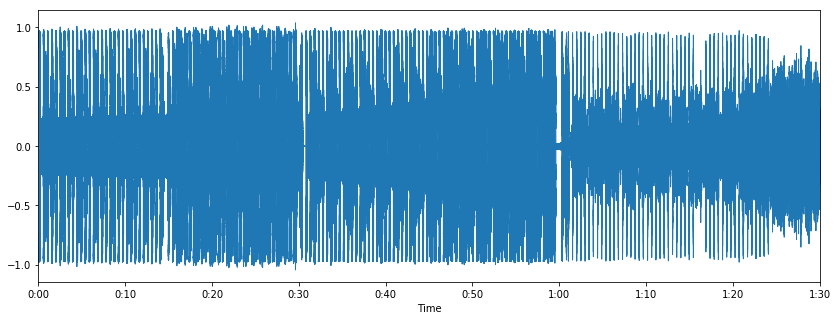

In [7]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x[:90*sr], sr=sr)
plt.show()

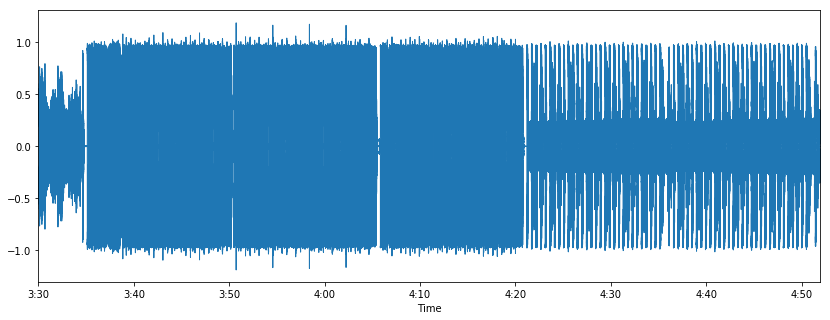

In [8]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x[210*sr:], sr=sr,offset = 210)
plt.show()

### Generating transitions
We will now briefly illustrate how these labels can be used to create smooth transitions. We will use the pydub package for basic audio manipulation. These transitions are relatively simple, using only tempo changes and crossfades. However, the underlying timing information can be used to create more sophisticated transitions which use EQ manipulation or effects - the fundamental aim of this work is to identify the correct timing. Example mixes containing only transitions created using these labels and the method below can be found on [Soundcloud](https://soundcloud.com/transition-models). [One mix](https://soundcloud.com/transition-models/transitionmodel-example-mix-1) was created using a manually selected tracklist to illustrate tempo changes using well-known songs. The [others](https://soundcloud.com/transition-models/sets/tracklist-generator-examples) were created by using the [Tracklist Generator](https://github.com/gmeehan96/tracklist-generator) to generate a variety of house music tracklists, before mixing these using the method below.

In [9]:
def match_target_amplitude(sound, target_dBFS):
    """Utility function which normalizes the average gain
        of an input audio segment in pydub"""
    
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

def speed_change(sound,speed=1.0):
    """Utility function for changing the tempo of the song 
        by multiplying by 'speed'
        
        Args:
            sound: pydub sound segment
            speed: ratio by which to change speed (e.g. 0.9 will
                slow down to 90% of original speed)
        
        Returns: 
            sound segment with changed speed
    """
    
    sound_with_altered_frame_rate = sound._spawn(sound.raw_data, overrides={
         "frame_rate": int(sound.frame_rate * speed)
      })
    return sound_with_altered_frame_rate.set_frame_rate(sound.frame_rate)


def get_starts_ends(song,labels_dict):
    """Pulls out the start and end timings for the intro and outro
        of a song
        
        Args:
            song: Song title
            labels_dict: Dictionary indexed by song title which 
                contains labelled transition points
        Returns:
            Lists containing start timestamps, end timestamps, and 
                possible transition lengths for both incoming and 
                outgoing transitions involving the song
    """
    df = labels_dict[song]    
    
    incoming = [str(x) for x in df.values[:,2].tolist()]
    incoming_starts = [i for i in range(len(incoming)) if 'Start' in incoming[i]]
    incoming_ends = [i for i in range(len(incoming)) if 'End' in incoming[i]]
    
    incoming_length_combos = [y-x for y in incoming_ends for x in incoming_starts]
    incoming_possible_lengths = list(set([n for n in incoming_length_combos if n > 0]))
    incoming_output = [incoming_starts,incoming_ends,incoming_possible_lengths]
    
    outgoing = [str(x) for x in df.values[:,3].tolist()]
    outgoing_starts = [i for i in range(len(outgoing)) if 'Start' in outgoing[i]]
    outgoing_ends = [i for i in range(len(outgoing)) if 'End' in outgoing[i]]
    
    outgoing_length_combos = [y-x for y in outgoing_ends for x in outgoing_starts]
    outgoing_possible_lengths = list(set([n for n in outgoing_length_combos if n > 0]))
    outgoing_output = [outgoing_starts,outgoing_ends,outgoing_possible_lengths]
    return incoming_output, outgoing_output

def get_transition_info(song_1,song_2):
    """Produces the configuration of a transition between two songs.
        
        Args:
            song_1: Title of outgoing song
            song_2: Title of incoming song
        
        Returns:
            song_1_start: Beat index of outgoing transition start in song_1.
                This is the earliest possible transition point with the
                relevant num_phrases.
            song_2_start: Beat index of incoming transition start in song_2.
                This is the earliest possible transition point with the
                relevant num_phrases.
            num_phrases: Length of the transition in phrases. This is the 
                maximum compatible transition length
    """
    _,song_1_outgoing = get_starts_ends(song_1)
    song_2_incoming,_ = get_starts_ends(song_2)
    
    poss_lengths = [x for x in range(1,4) if \
                    32*x in song_1_outgoing[-1] and 32*x in song_2_incoming[-1]]
    num_phrases = np.max(poss_lengths)
    num_beats = 32*num_phrases
    song_1_start = np.min([x for x in song_1_outgoing[0] if x+num_beats in song_1_outgoing[1]])
    song_2_start = np.min([x for x in song_2_incoming[0] if x+num_beats in song_2_incoming[1]])
    
    return song_1_start,song_2_start,num_phrases

def get_transition(song_1,song_2,
                   labels_dict,
                   name_filenames_map,
                   prologue_length = 128,
                   offsets = [8,16,32,32]):
    """Main function for generating a transition between two songs. It produces
        a pydub audio segment containing the transition itself as well as a 
        prelude of the outgoing song and a prologue of the incoming song to give
        additional context.
        
        The full transition is divided into three stages:
            
            - In the prelude stage, the two phrases immediately preceding the 
                start of the transition in the incoming song are played. During
                this time, the tempo of the outgoing song is changed to match
                the tempo of the incoming song if necessary.
            - In the transition stage, the outgoing song is faded out and the 
                incoming song is faded in. There is an offset so that the 
                outgoing song begins its fade out a bit later than the incoming
                song starts to come in, and the incoming song is up to full 
                volume before the outgoing song is fully faded out. This keeps 
                the gain level more consistent.
            - In the prologue stage, a few more phrases of the incoming song are
                played to give more context to the transition.
        
        Args:
            song_1: Title of outgoing song
            song_2: Title of incoming song
            labels_dict: Dictionary indexed by song title which contains labelled 
                transition points
            name_filenames_map: Dictionary indexed by song title which contains
                the location of the MP3 file
            prologue_length: The number of beats of the incoming song to play 
                after the transition is complete
            offsets: The number of beats to offset the fade in of the incoming song
                by depending on the length of the transition in phrases
        Returns:
            transition: pydub audio segment containing the full transition with 
                prelude and prologue. This can easily be exported as a .wav file.
    
    """
    song_1_start,song_2_start,num_phrases = get_transition_info(song_1,song_2)
    
    song_1_bpm = get_bpm(song_1)
    song_2_bpm = get_bpm(song_2)
    
    song_1_beats = labels_dict[song_1].values[:,0]
    song_2_beats = labels_dict[song_2].values[:,0]
    
    song_1_seg = match_target_amplitude(
        AudioSegment.from_mp3(name_filenames_map[song_1]), -10.0)
    song_2_seg = match_target_amplitude(
        AudioSegment.from_mp3(name_filenames_map[song_2]), -10.0)
    
    from_bpm = np.round(song_1_bpm,1)
    to_bpm = np.round(song_2_bpm,1)
    avg_bpm = (from_bpm+to_bpm)/2
    
    #Beat times are multiplied by 1000 because pydub audio segments are indexed in milliseconds
    song_1_rest = song_1_seg[song_1_beats[song_1_start-64]*1000:song_1_beats[song_1_start-32]*1000]
    song_1_prelude = speed_change(
        song_1_seg[song_1_beats[song_1_start-32]*1000:song_1_beats[song_1_start-16]*1000],
        avg_bpm/from_bpm)
    song_1_prelude_2 = speed_change(
        song_1_seg[song_1_beats[song_1_start-16]*1000:song_1_beats[song_1_start]*1000],
        to_bpm/from_bpm)
    
    song_1_start_time = int(song_1_beats[song_1_start]*1000)
    song_1_offset = int(song_1_beats[song_1_start+offsets[num_phrases-1]]*1000)
    song_1_end_time = int(song_1_beats[song_1_start+32*num_phrases]*1000)    
    
    
    song_1_transition = speed_change(song_1_seg[song_1_start_time:song_1_offset],to_bpm/from_bpm)
    song_1_transition_rest = speed_change(song_1_seg[song_1_offset:song_1_end_time],to_bpm/from_bpm)
    song_1_transition += song_1_transition_rest.fade_out(len(song_1_transition_rest))
    
    
    song_2_start_time = int(song_2_beats[song_2_start]*1000)
    song_2_end_time = int(song_2_beats[song_2_start+32*num_phrases]*1000)

    song_2_transition = song_2_seg[song_2_start_time:song_2_end_time].fade_in(
        2*(song_1_offset-song_1_start_time))
    
    transition_finish_time = song_2_beats[song_2_start+32*num_phrases+prologue_length]*1000
    
    song_2_prologue = song_2_seg[song_2_end_time:transition_finish_time]
    
    transition = pydub.effects.normalize(song_1_rest+song_1_prelude + song_1_prelude_2 )
    transition += pydub.effects.normalize(song_2_transition.overlay(song_1_transition))
    transition += pydub.effects.normalize(song_2_prologue)
    
    return pydub.effects.normalize(transition)

def get_transition_tl(tl,labels_dict,name_filenames_map):
    """Wrapper function which creates a full mix given a tracklist of song titles
    
        Args:
            tl: List of song titles
            labels_dict: Dictionary indexed by song title which contains labelled 
                transition points
            name_filenames_map: Dictionary indexed by song title which contains
                the location of the MP3 file
        
        Returns:
            mix: pydub audio segment containing the full mix. This can 
                easily be exported as a .wav file.
    """
    transition_infos = []
    for i in range(len(tl)-1):
        transition_infos.append(get_transition_info(tl[i],tl[i+1]))
    
    #We initialise the mix with the start of the first song
    first_song_seg = match_target_amplitude(
        AudioSegment.from_mp3(name_filenames_map[tl[0]]), -10.0)
    
    mix = first_song_seg[:labels_dict[tl[0]].values[transition_infos[0][0]-64,0]*1000]
    
    for i in range(len(tl)-1):
        try:
            next_ind = transition_infos[i+1][0]-64 - transition_infos[i][1]
        except IndexError:
            #We need to add on the remainder of the final song
            next_ind = labels_dict[tl[-1]].shape[0] - transition_infos[-1][-1]*32\
                    - transition_infos[-1][1]- 1 
        mix += get_transition(tl[i],tl[i+1],transition_infos[i],next_ind)
    return mix

We can see below the separate song_1 and song_2 waveforms of the transition section for an example transition, to illustrate the fade in and fade out points.

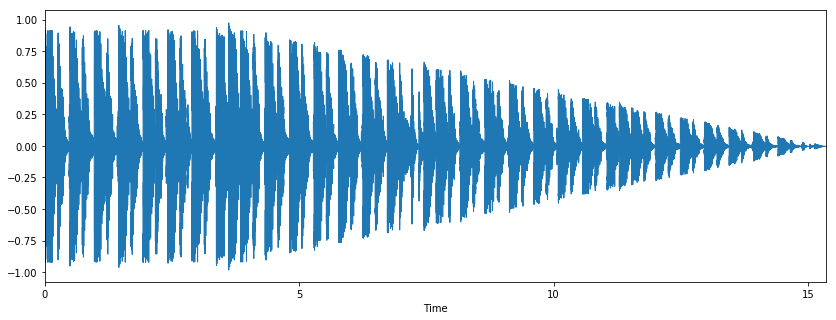

In [10]:
s1, sr = librosa.load('song_1_transition.wav')
plt.figure(figsize=(14, 5))
librosa.display.waveplot(s1, sr=sr)
plt.show()

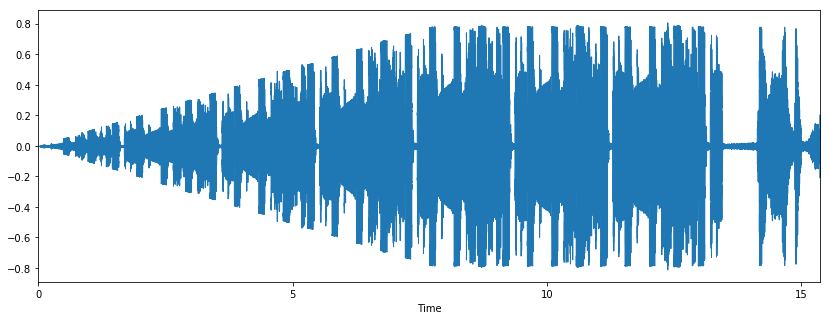

In [11]:
s2, sr = librosa.load('song_2_transition.wav')
plt.figure(figsize=(14, 5))
librosa.display.waveplot(s2, sr=sr)
plt.show()

## Audio Features
Once the songs have been labelled, we need to extract from each MP3 the audio features to be used as input into the DJ Transition Model. We have chosen to take a deep learning approach directly on the [Mel Spectrogram](https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html) and [Chromagram](https://librosa.org/doc/main/generated/librosa.feature.chroma_cqt.html) of the song. We will extract these using the librosa package. 

In [12]:
def get_grams(filename):
    """Extracts chromagram and mel spectrogram from MP3 file using
        the librosa package.
        
        Args: 
            filename: directory of an MP3 file
        
        Returns:
            chromagram: chromagram numpy array of shape (t,12)
            spectrogram: Mel spectrogram numpy array of shape (t,128)
    """
    
    y, sr = librosa.load(filename)

    chromagram = librosa.feature.chroma_cqt(y=y,
                                        sr=sr,hop_length = 256)

    spectrogram = librosa.feature.melspectrogram(y=y,
                                        sr=sr,hop_length = 256)
    
    return chromagram.T, spectrogram.T

In [13]:
chromagram,spectrogram = get_grams('chris_lake_-_lose_my_mind.mp3')
print('Chromagram shape: ',chromagram.shape)
print('Mel spectrogram shape: ',spectrogram.shape)

Chromagram shape:  (25142, 12)
Mel spectrogram shape:  (25142, 128)


We can plot the chromagram and spectrogram for this song:

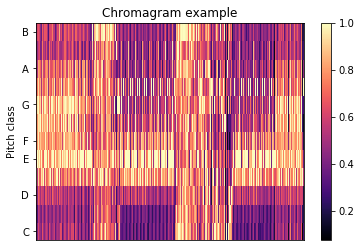

In [14]:
fig, ax = plt.subplots()
img = librosa.display.specshow(chromagram.T, y_axis='chroma', ax=ax)
ax.set(title='Chromagram example')
fig.colorbar(img, ax=ax)
plt.show()

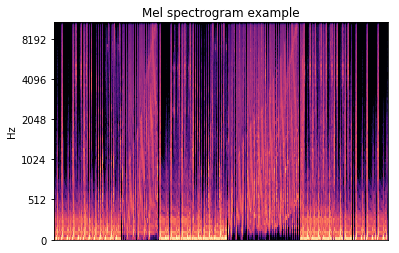

In [15]:
fig, ax = plt.subplots()
spectrogram_db = librosa.power_to_db(spectrogram.T, ref=np.max)
img = librosa.display.specshow(spectrogram_db,
                               y_axis='mel', ax=ax)
ax.set(title='Mel spectrogram example')
plt.show()

We performed this feature extraction for each song and saved to a dictionary indexed by song name. Further processing is performed in the model training notebooks to slice the audio feature arrays appropriately for input into our models.